In [ ]:
##FILLER MARKDOWN CELL --- DO NOT DELETE

In [1]:
# Install necessary libraries
!pip install ultralytics
!pip install plotly
!pip install opencv-python-headless
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!pip install --upgrade wandb
!pip install --upgrade typing_extensions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 72.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.22.2
    Uninstalling wandb-0.22.2:
      Successfully uninstalled wandb-0.22.2


In [4]:
#importing wandB
import wandb
os.environ['WANDB_API_KEY'] = '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'

#my api key
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.
wandb: Currently logged in as: carlos-a_marin (carlos-a_marin-n-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Paths to data directories
train_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
val_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val"

In [6]:
#creating classes 
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

### Purpose
The function **load_data** is designed to load images and their corresponding labels from a directory structure. It processes these images and labels and stores them in lists.

### Parameters
**data_path**: The root directory where the image and label data is stored.


**images**: A list that will store the loaded images.

**labels**: A list that will store the labels corresponding to the images.

### Loop and Processing
#### Class Loop:

The function iterates over a variable classes, which is expected to be a list of class labels. 

#### Paths Construction:

For each class_label in classes, it constructs paths to the images and labels directories:

**class_path**: Path to the directory containing images for the current class.

**label_path**: Path to the directory containing labels for the current class.

### Image and Label Processing:

It loops through each file in class_path (the images directory).
For each image file:

Read the Image: **cv2.imread** reads the image from the file.

Convert Color: **cv2.cvtColor** converts the image color format from BGR (used by OpenCV) to RGB.
#### Construct Label File Path:
The label file name is generated by replacing the .jpg extension of the image file name with .txt.
It constructs the path to the corresponding label file.
### Check for Label File:
If the label file exists, it reads the file, processes the contents, and splits them into a list of label data.
If the label file is not empty, it appends the image and its corresponding label data to the images and labels lists, respectively.
If the label file is empty, it prints a message and skips that image.
If the label file does not exist, it prints a message and skips that image.
Return
Finally, the function returns the images and labels lists.

In [7]:
# Function to load images and labels
def load_data(data_path):
    images = []
    labels = []
    for class_label in classes:
        class_path = os.path.join(data_path, class_label, 'images')
        label_path = os.path.join(data_path, class_label, 'labels')
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_file = img_file.replace('.jpg', '.txt')
            label_file_path = os.path.join(label_path, label_file)
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    return images, labels

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/labels/gg (342).txt is empty, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(55).txt not found, skipping this image.


In [8]:
#Image processing
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img (640, 640))
        processed_images.append(img_resized)
        return np.array(processed_images)

In [9]:
# Create YOLOv10 Dataset Configuration File
dataset_yaml = {
    'path': '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes',
    'train': 'Train',
    'val': 'Val',
    'names': classes
}

with open('/kaggle/working/dataset.yaml', 'w') as file:
    yaml.dump(dataset_yaml, file)

In [10]:
#Yolo Model training
yolo_model = YOLO("yolo26n.pt")

train_results = yolo_model.train(data='/kaggle/working/dataset.yaml', epochs=30, imgsz=640)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

In [12]:
yolo_model.save('/kaggle/working/yolo26_model.pt')

In [13]:
#creating f1 score function that calculates f1 score given precision and recall

def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0  # Avoid division by zero if both precision and recall are 0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

#Mean f1 score
precision = 0.957
recall = 0.922
Mean_f1_score = calculate_f1_score(precision, recall)
print('Mean F1 Score: ',Mean_f1_score)

#Glioma f1 Score
precison = 0.936      
recall  = 0.856
Glioma_f1_score = calculate_f1_score(precision, recall)
print('Glioma F1 Score: ',Glioma_f1_score)

#Meningioma f1 Score
precison = 0.993     
recall  = 0.979
Meningioma_f1_score = calculate_f1_score(precision, recall)
print('Meningioma F1 Score: ',Meningioma_f1_score)

#No Tumor  f1 Score
precison = 0.964     
recall  = 0.99
No_Tumor_f1_score = calculate_f1_score(precision, recall)
print('No Tumor F1 Score: ',No_Tumor_f1_score)

#Pituitary f1 Score
precison = 0.934     
recall  = 0.863
Pituitary_f1_score = calculate_f1_score(precision, recall)
print('Pituitary F1 Score: ',Pituitary_f1_score)

Mean F1 Score:  0.9391740287386907
Glioma F1 Score:  0.9036867071152784
Meningioma F1 Score:  0.9678749999999999
No Tumor F1 Score:  0.9732203389830508
Pituitary F1 Score:  0.9075725274725275


In [22]:
### MARKDOWN CELL TO INTERPRET RESULTS

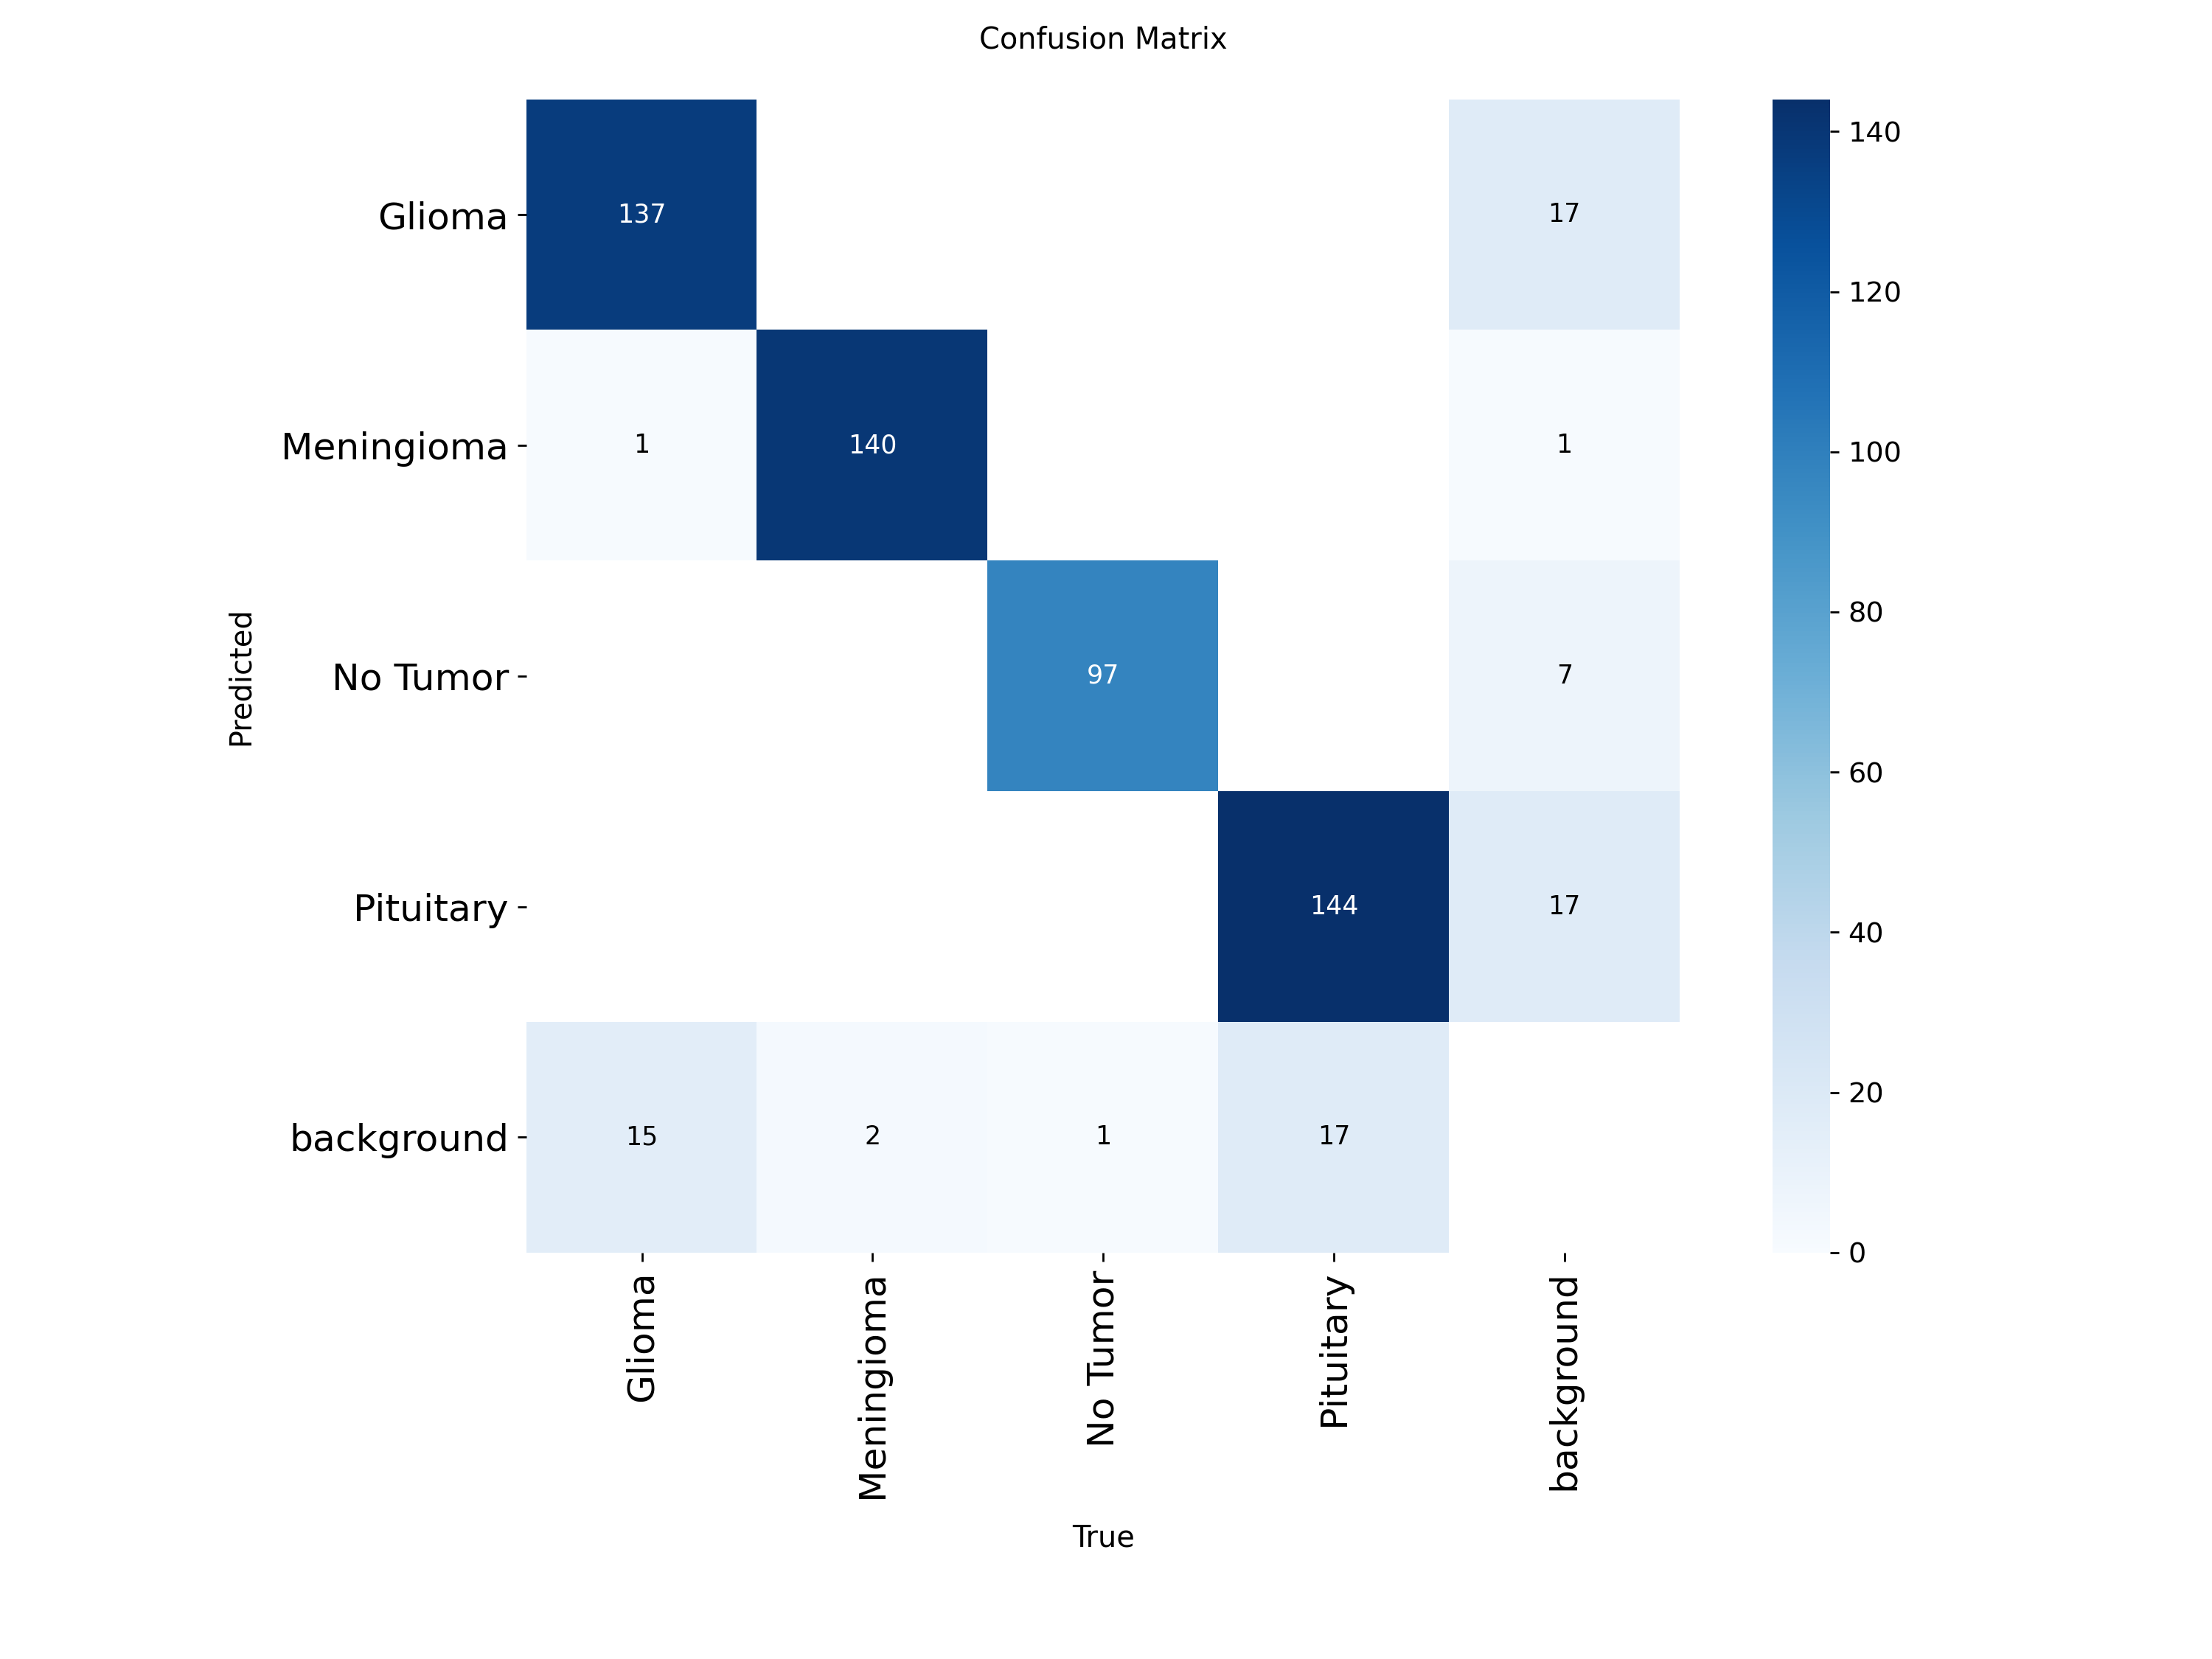

In [14]:
from IPython.display import Image, display

# Path to the confusion matrix generated by your training run
cm_path = '/kaggle/working/runs/detect/train/confusion_matrix.png'

display(Image(filename=cm_path))


0: 640x640 1 Glioma, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


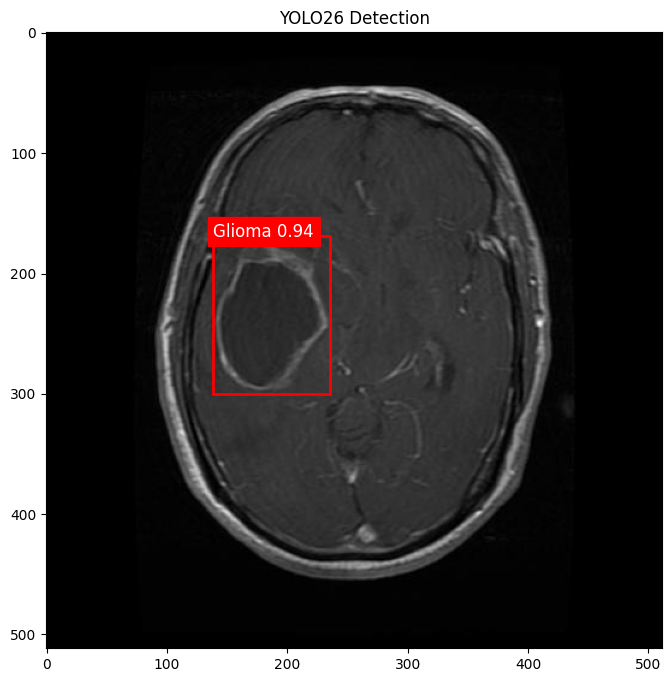


0: 640x640 1 Glioma, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


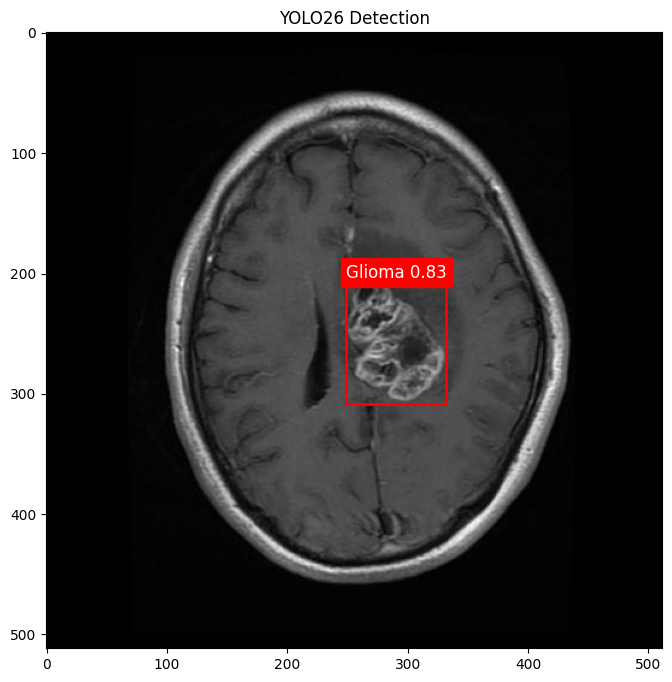


0: 640x640 1 Glioma, 10.0ms
Speed: 3.1ms preprocess, 10.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


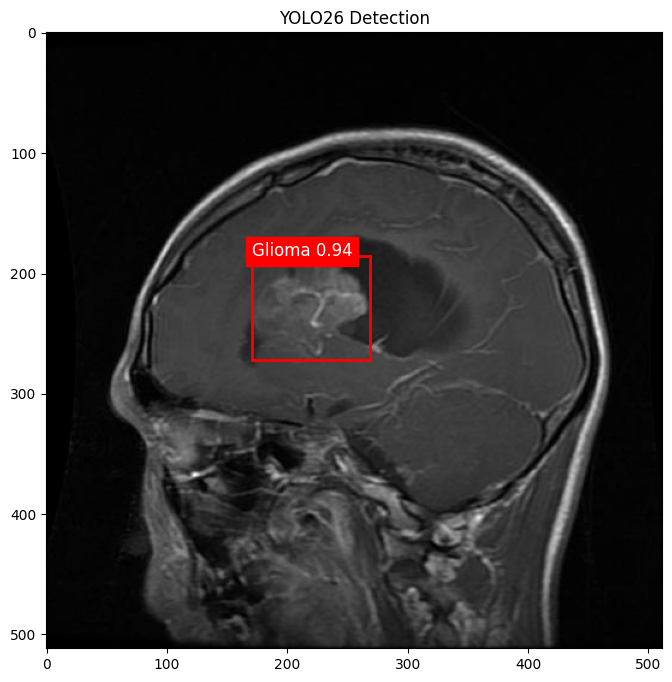


0: 640x640 1 Glioma, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


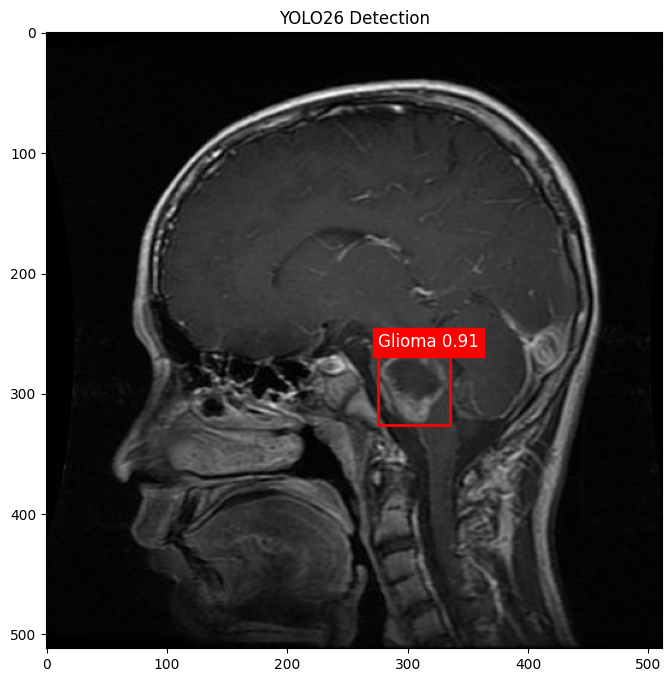


0: 640x640 1 Glioma, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


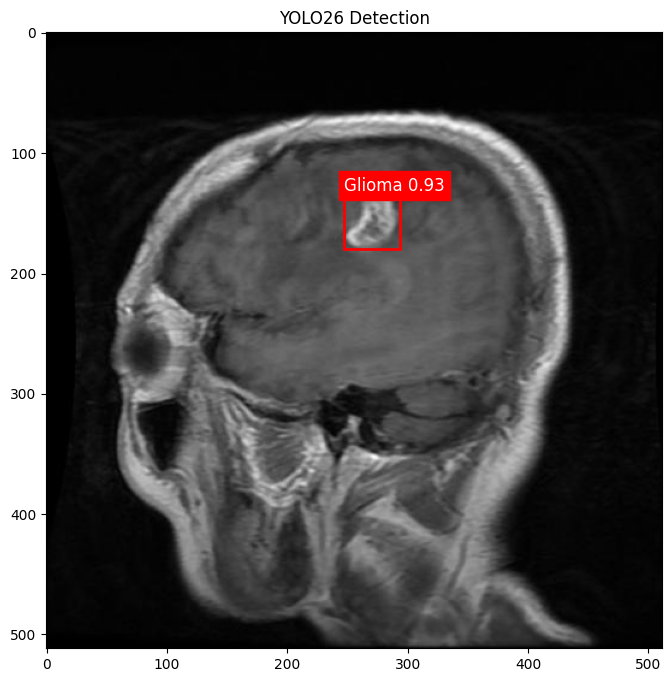


0: 640x640 2 Gliomas, 10.4ms
Speed: 3.0ms preprocess, 10.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


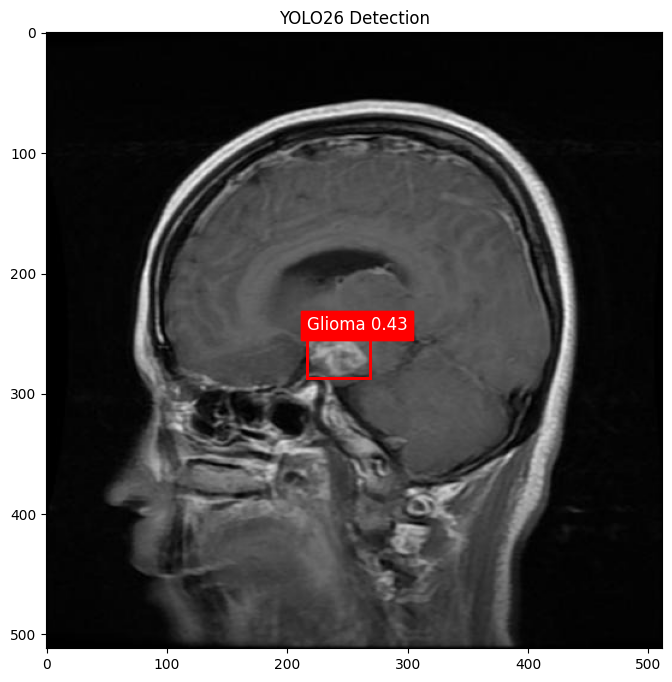


0: 640x640 1 Glioma, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


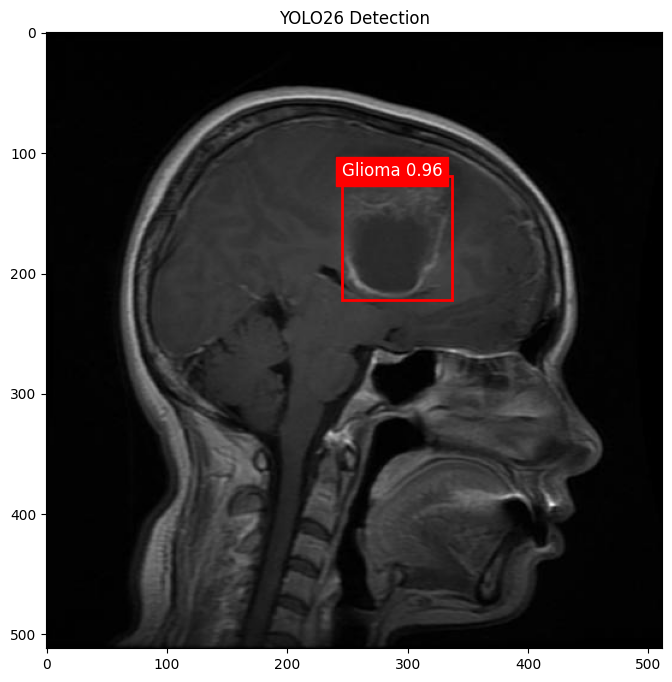


0: 640x640 1 Glioma, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


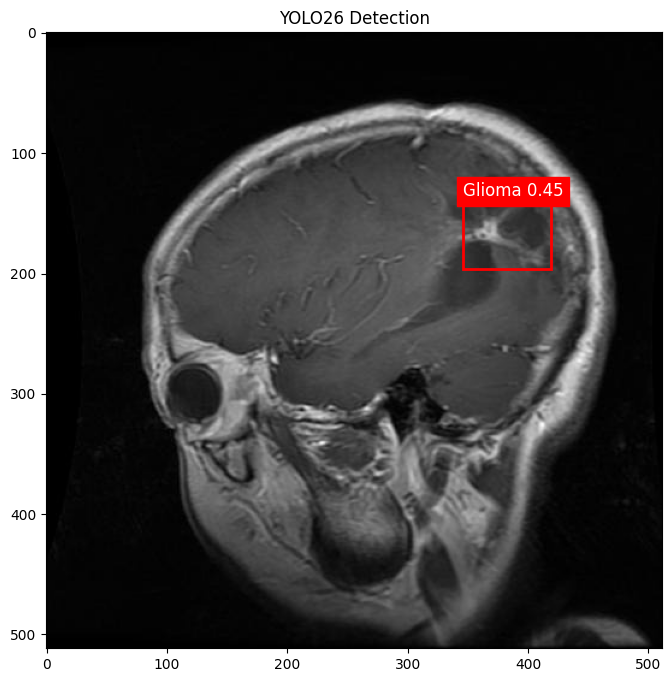


0: 640x640 1 Glioma, 1 Pituitary, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


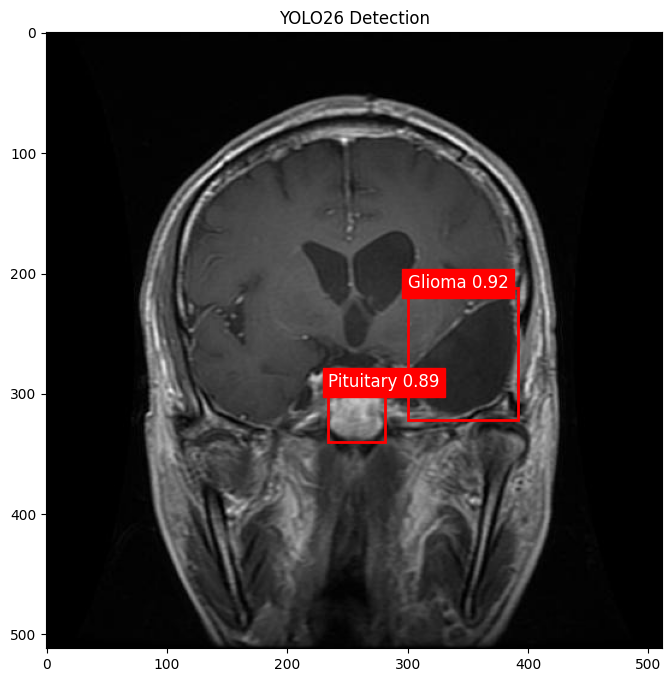


0: 640x640 1 Glioma, 10.2ms
Speed: 3.1ms preprocess, 10.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


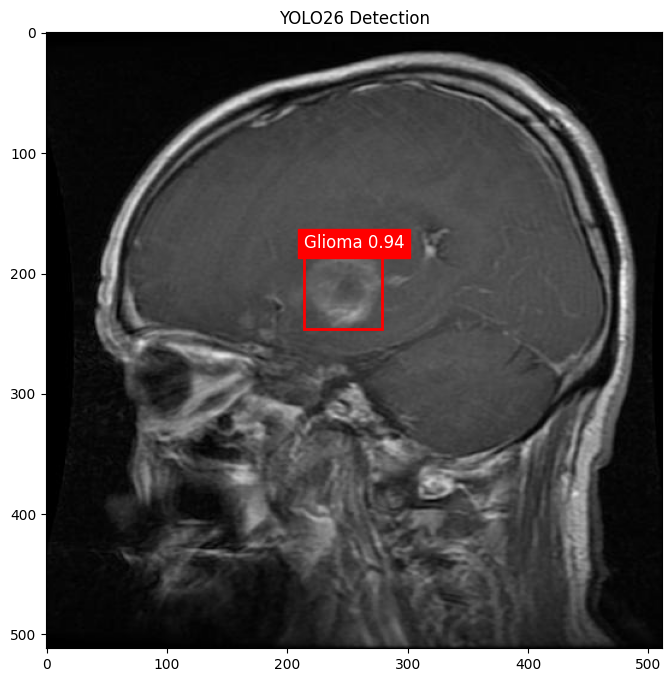

In [15]:
# Function to display detection results with highlighted parts
def display_samples(images, yolo_model):
    for i in range(10):
        img = images[i]
        result = yolo_model.predict(img)[0]  # Assuming batch size of 1, take the first result

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for detection in result.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = detection.cls[0].cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f"{classes[int(cls)]} {conf:.2f}", color='white', fontsize=12, backgroundcolor='red')
        
        plt.title(f'YOLO26 Detection')
        plt.show()

display_samples(val_images, yolo_model)

In [16]:
#defining function to load datasets for visualization purposes
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [17]:
# Paths to data directories
train_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train/"
val_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/"
#Creating Sample Training dataFrame for image visualization
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_path)
train.head()

Pituitary Completed
No Tumor Completed
Meningioma Completed
Glioma Completed


,image,label
0,/kaggle/input/mri-for-brain-tumor-with-boundin...,Pituitary
1,/kaggle/input/mri-for-brain-tumor-with-boundin...,Pituitary
2,/kaggle/input/mri-for-brain-tumor-with-boundin...,No Tumor
3,/kaggle/input/mri-for-brain-tumor-with-boundin...,No Tumor
4,/kaggle/input/mri-for-brain-tumor-with-boundin...,Meningioma


<Axes: xlabel='count', ylabel='label'>

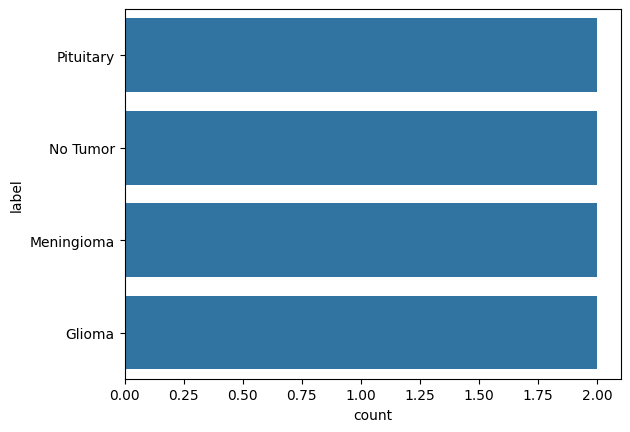

In [18]:
import seaborn as sns 
#Performing data visualization on image distribution. 
sns.countplot(train['label'])

/tmp/ipykernel_55/1327263906.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Tumor Type', palette='magma')


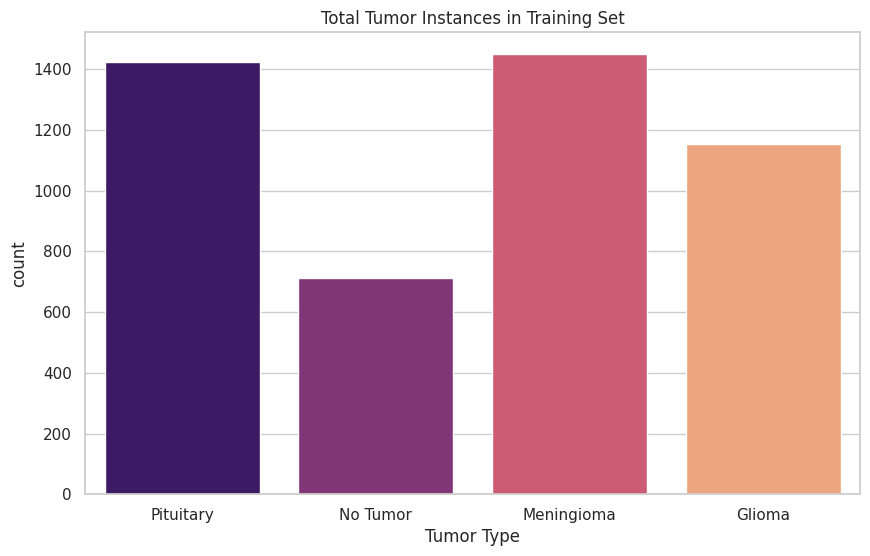

In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Path to your 'Train' folder from the screenshot
root_dir = '/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train'

data_summary = []

# 2. Walk through every subfolder
for root, dirs, files in os.walk(root_dir):
    # We only care about files in 'labels' folders
    if os.path.basename(root) == 'labels':
        # Get the class name from the parent folder (e.g., Glioma)
        class_name = os.path.basename(os.path.dirname(root))
        
        # Count every .txt file in this specific labels folder
        for file in files:
            if file.endswith('.txt'):
                data_summary.append(class_name)

# 3. Create the plot
if data_summary:
    df = pd.DataFrame(data_summary, columns=['Tumor Type'])
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    # Use 'order' to make sure classes appear in a logical sequence
    sns.countplot(data=df, x='Tumor Type', palette='magma')
    plt.title('Total Tumor Instances in Training Set')
    plt.show()
else:
    print("No labels found. Double-check your root_dir path!")